# Analysis for Derivative Higgs Portal Scalar

In this notebook we show how we use a neural-network classifier to separate the invisible Higgs portal scalar signal from the background and derive a bound on the derivative portal coupling $f/\sqrt{c_d}$ (see Section IV in the paper for details). Here we present the analysis for one exemplary mass point of $m_\phi = 300$ GeV and an assumed energy resolution of $\delta_{\rm res}=10\%$ for the forward muons.\
We first load the data which consists of up to 50k events for the signal and each background process from .csv files. Each event contains 11 features which provide a redundant description of the kinematics and which are used as input for the classifier
\begin{equation}
\begin{split}
        &\log \big(p_\bot^{\mu^{\pm}} \big)\,,\;\;\; \eta_{\mu^{\pm}}\,,\;\;\; \cos(\Delta\phi_{\mu\mu})\,,\;\;\;  \sin(\Delta\phi_{\mu\mu})\,, \\
       &|\Delta\eta_{\mu\mu}|\,,\quad M_{\rm rec}\,,\quad \log (P_\bot^{\mu\mu})\,,\quad M_{\mu\mu}\,,\quad E_\mu^{\rm min}\,.
\end{split}
\end{equation} 
We use an architecture with 11-30-30-1 nodes in linear layers connected by sigmoid activation functions.
We split each set of events into training data ($80\%$) and validation data ($20\%$) and train the network on the training data such as to minimize the cross-entropy loss on the validation set. We finally use the performance on the validation set as an estimate of the signal selection efficiency.\
As an additional complication we read in the parton-level $MIM$ and apply a $MIM < 4\pi f$ cut in order to make sure all signal events can be described within the validity of the EFT.

In [1]:
from Simple_Classifier import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate

Specify signal and background cross-sections and load background events

In [2]:
### sigInfo = {mass: Xsect,...}
sigInfo = {
    300: 0.000741397
}

### import background features
bckinfo = {
    'mumununu': 0.112716,
    'mumua': 2.75146, 
    'mumuaa': 0.1554,
    'mumuww': 0.0267102,
    'mumuff': 0.127129,
    'mumumumu': 0.0220756 }
bckfeatures = {}
bckinfo['mumununu']
for name in bckinfo.keys():
    print(name)
    bckfeatures[name] = torch.tensor(pd.read_csv(os.getcwd()+'/Data/BG/'+name+'.csv').to_numpy())
    print(bckfeatures[name].size())

mumununu
torch.Size([43824, 11])
mumua
torch.Size([49999, 11])
mumuaa
torch.Size([49999, 11])
mumuww
torch.Size([41114, 11])
mumuff
torch.Size([40678, 11])
mumumumu
torch.Size([49999, 11])


Split dataset into training and validation set and create labels

In [3]:
Tf = []
Vf = []
Tw = []
Vw = []
for name in bckinfo.keys():
    index = int(np.floor(0.8*len(bckfeatures[name])))
    Tf.append(bckfeatures[name][0:index])
    Vf.append(bckfeatures[name][index+1:-1])
    Tw.append(bckinfo[name]*torch.ones([Tf[-1].size()[0],1])/Tf[-1].size()[0])
    Vw.append(bckinfo[name]*torch.ones([Vf[-1].size()[0],1])/Vf[-1].size()[0])
Tfeatures0=torch.cat(Tf)
Vfeatures0=torch.cat(Vf)
Tweights0=torch.cat(Tw)
Tweights0=Tweights0/Tweights0.sum()
Tlabels0=torch.zeros([Tfeatures0.size()[0],1])
Vweights0=torch.cat(Vw)
Vweights0=Vweights0/Vweights0.sum()
Vlabels0=torch.zeros([Vfeatures0.size()[0],1])

Define significance function, one version with and one without the $MIM < 4\pi f$ cut

In [4]:
def Significance(classifier, cut, bginfo, sigXsectNull, f):
    bgXsect = 0.0
    with torch.no_grad():
        # loop through all backgrounds and compute cross-section for all events that survive the 
        # classifier cut in the validation set
        for name in bginfo.keys():
            index = int(np.floor(0.8*len(bckfeatures[name])))
            bah = pd.Series(classifier(bckfeatures[name][index+1:-1].float()).detach().numpy()[:,0])
            bgXsect += bah[(bah > cut)].size/bah.size*bginfo[name]
    # compute the signal cross-section for all events that survive the classifier cut in the 
    # validation set and implement the cut on the parton-level MIM to check for EFT validity
    indexSig = int(np.floor(0.8*len(featuresOSHiggs)))
    with torch.no_grad():
        bah = pd.Series(classifier(featuresOSHiggs[indexSig+1:-1].float()).detach().numpy()[:,0])
    sigXsect = bah[(bah > cut)&(MIMtruthVal < 12.5664*f)].size/bah.size*sigXsectNull*500**4/f**4
    # return significance
    return sigXsect*1e7/np.sqrt(sigXsect*1e7+bgXsect*1e7)

def SignificanceSearch(classifier, cut, bginfo, sigXsectNull, f):
    bgXsect = 0.0
    with torch.no_grad():
        # loop through all backgrounds and compute cross-section for all events that survive the 
        # classifier cut in the validation set
        for name in bginfo.keys():
            index = int(np.floor(0.8*len(bckfeatures[name])))
            bah = pd.Series(classifier(bckfeatures[name][index+1:-1].float()).detach().numpy()[:,0])
            bgXsect += bah[(bah > cut)].size/bah.size*bginfo[name]
    # compute the signal cross-section for all events that survive the classifier cut in the 
    # validation set and implement the cut on the parton-level MIM to check for EFT validity
    indexSig = int(np.floor(0.8*len(featuresOSHiggs)))
    with torch.no_grad():
        bah = pd.Series(classifier(featuresOSHiggs[indexSig+1:-1].float()).detach().numpy()[:,0])
    sigXsect = bah[(bah > cut)].size/bah.size*sigXsectNull*500**4/f**4
    # return significance
    return sigXsect*1e7/np.sqrt(sigXsect*1e7+bgXsect*1e7)

Train the classifier and plot the bound on $f/\sqrt{c_d}$ as a function of the cut on the classifier output on the validation set. Finally we give the two-sided bound for each choice of cut on the classifier output with the addition of the EFT validity codition.

0.000741397
torch.Size([49999, 11])
for i in self.children(): print(i) command returns model structure, which is:

Linear(in_features=11, out_features=30, bias=True)
Sigmoid()
Linear(in_features=30, out_features=30, bias=True)
Sigmoid()
Linear(in_features=30, out_features=1, bias=True)




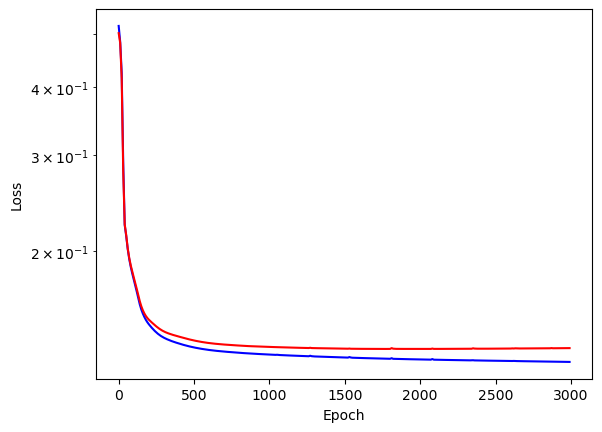

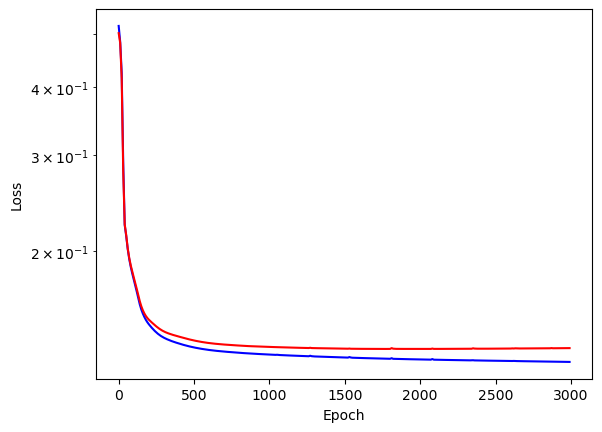

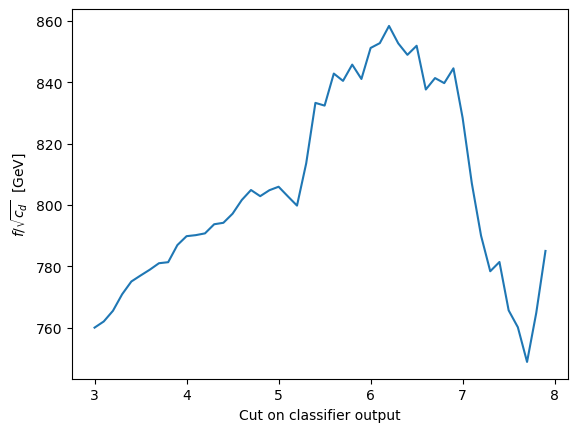

Result for m=300 GeV:
[(3.0, 760.0592476396998), (3.1, 762.0639618616993), (3.2, 765.5478804865584), (3.3000000000000003, 770.9432718555837), (3.4000000000000004, 775.0931851027287), (3.5000000000000004, 777.0421804789873), (3.6000000000000005, 778.9314156190535), (3.7000000000000006, 781.0453778958203), (3.8000000000000007, 781.3806036276218), (3.900000000000001, 786.9561475444949), (4.000000000000001, 789.8611952165566), (4.100000000000001, 790.196745575533), (4.200000000000001, 790.7721220865101), (4.300000000000001, 793.7449063501574), (4.400000000000001, 794.2183500405963), (4.500000000000002, 797.1834561295225), (4.600000000000001, 801.6485896661745), (4.700000000000001, 804.901605202273), (4.800000000000002, 802.8963048672877), (4.900000000000002, 804.8352004736951), (5.000000000000002, 805.9721991334704), (5.100000000000001, 802.8642103334308), (5.200000000000002, 799.821524200109), (5.3000000000000025, 813.5958735045627), (5.400000000000002, 833.2978834422142), (5.500000000000

In [5]:
masslist = [300]

for mass in masslist:
    sigXsect=sigInfo[mass]
    print(sigXsect)
    ### import signal features
    featuresOSHiggs=torch.tensor(pd.read_csv(os.getcwd()+'/Data/derivative_portal/mumuPhiPhi_'+str(mass)+'_der.csv').to_numpy())
    MIMtruth=pd.read_csv(os.getcwd()+'/Data/derivative_portal/mumuPhiPhi_'+str(mass)+'_der_MIMTruth.csv')[0:49999].squeeze().reset_index(drop=True)
    ### create training and validation set
    indexSig = int(np.floor(0.8*len(featuresOSHiggs)))
    Tfeatures1=featuresOSHiggs[0:indexSig]
    Vfeatures1=featuresOSHiggs[indexSig:-1]
    Tweights1=torch.ones([Tfeatures1.size()[0],1])/Tfeatures1.size()[0]
    Tlabels1=torch.ones([Tfeatures1.size()[0],1])
    Vweights1=torch.ones([Vfeatures1.size()[0],1])/Vfeatures1.size()[0]
    Vlabels1=torch.ones([Vfeatures1.size()[0],1])
    print(featuresOSHiggs.size())
    
    ### join training and validation data
    Tfeatures=torch.cat((Tfeatures0,Tfeatures1),0)
    Tlabels=torch.cat((Tlabels0,Tlabels1),0)
    Tweights=torch.cat((Tweights0,Tweights1),0)
    Vfeatures=torch.cat((Vfeatures0,Vfeatures1),0)
    Vlabels=torch.cat((Vlabels0,Vlabels1),0)
    Vweights=torch.cat((Vweights0,Vweights1),0)
    
    ### set up classifier
    cCE=SimpleClassifier([11,30,30,1], verbose = True)
    cCE.setscaling(featuresOSHiggs.float())
    tCE=SimpleTrainer([Tfeatures.float(), Tweights.float(), Tlabels.float()] \
                    ,[Vfeatures.float(), Vweights.float(), Vlabels.float()], \
                    NumEpochs = 3000, \
                    SaveAtEpochs = ["SaveCE", [1000, 2000, 3000]],\
                              LossFunction ='CrossEntropy', LearningRate = 1e-2)
    
    ### train classifier
    cCETrained = tCE.train(cCE)
    
    ### plot significance
    MIMtruthVal = MIMtruth[indexSig+1:-1].reset_index(drop=True)
    cuts = np.arange(3,8,0.1)
    lamData = []
    lamDataFull = []
    for c in cuts:
        func = lambda lam : SignificanceSearch(cCETrained, c, bckinfo, sigXsect, lam) - 1.64
        lamData.append(fsolve(func, 500.0).item())
        func2 = lambda lam : Significance(cCETrained, c, bckinfo, sigXsect, lam) - 1.64
        x=np.arange(5,1000,5)
        y=[func2(val) for val in x]
        tck = interpolate.splrep(x,y,s=0)
        lamDataFull.append(interpolate.sproot(tck))
    fig, ax = plt.subplots()
    ax.plot(cuts,lamData)
    ax.set_xlabel('Cut on classifier output')
    ax.set_ylabel(r'$f/\sqrt{c_d}$  [GeV]')
    plt.show()
    print('Result for m='+str(mass)+' GeV:')
    print(list(zip(cuts,lamData)))
    print('Full Result for m='+str(mass)+' GeV:')
    print(list(zip(cuts,lamDataFull)))

The optimal bound is obtained for $c>6.2$, where $c$ is the classifier output. It yields a bound of $45\text{ GeV} < f/\sqrt{c_d} < 858\text{ GeV}$. (Note that rerunning this notebook can yield slightly different results since the weights of the neural network are initialized with random values)